# *Monod* demonstration: distinguishing models of transcriptional variation

We ran the *Monod* inference pipeline on thirteen datasets: pre-clustered mouse brain cell data, disaggregated into GABAergic and glutamatergic cell types, and five 10X Genomics mouse tissue samples. Each dataset was fit using the bursty, constitutive, extrinsic, and CIR models for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given maximum likelihood estimates under each model, we can apply the standard Akaike Information Criterion framework to attempt to assign probabilities to the models. These estimates are necessarily incomplete, as they do not take into account the parameter uncertainties; further, they appear to overestimate confidence in model selections. However, this is an essential first step toward exploring model ensembles. 

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [7]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [9]:
models = ('Bursty','Extrinsic','CIR')
n_models = len(models)

In [4]:
n_models = len(models)

In [13]:
dataset_meta = ['B08','C01','F08','H12']
subcluster_names = ['l23it','l5it','l6it','l5et', 'l56np', 'l6ct', 'l6b']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 

dir_string = './fits/gg_220602_022_allen_celltypes_1'
n_datasets = len(dataset_names)


In [14]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'
result_strings = [[dir_string+'/'+x+'/'+y+'_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names] \
                  for y in models]
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]

# res = [dir_string1+'/'+x for x in dn1]

# dn2 =  ['heart_1k','heart_10k','neuron_1k','neuron_10k','brain_5k']
# dn2 = [x+'_v3' for x in dn2]
# dataset_names = dn1 + dn2

# dir_string2 = './fits/gg_220526_021_modelcomp_1'
# res += [dir_string2+'/'+x for x in dn2]

# result_strings = [[x+'/'+model+'_Poisson_20x21/grid_scan_results.res' for model in models] for x in res]

# sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] + [dir_string2+'/'+x+'/raw.sd' for x in dn2]


In [15]:
result_strings

[['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5et/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l56np/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6ct/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6b/Bursty_Poisson_20x21/grid_scan_results_upd.res'],
 ['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltyp

In [16]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr_ = []
    for k in range(n_models):
        sr_.append(load_search_results(result_strings[k][j]))
    
    sd_arr.append(sd)
    sr_arr.append(sr_)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/CIR_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5

In [17]:
len(sr_arr)

7

## AIC weight computation

Now, we iterate over the results for all of the models, identify the parameter optima, and compute Akaike weights according to the procedure in Burnham and Anderson (2002).

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l23it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5et.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l56np.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6ct.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6b.png.


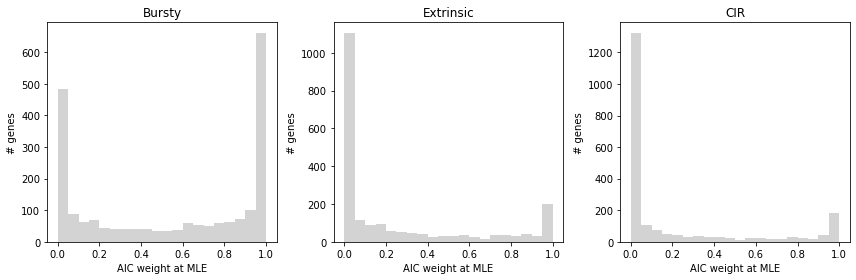

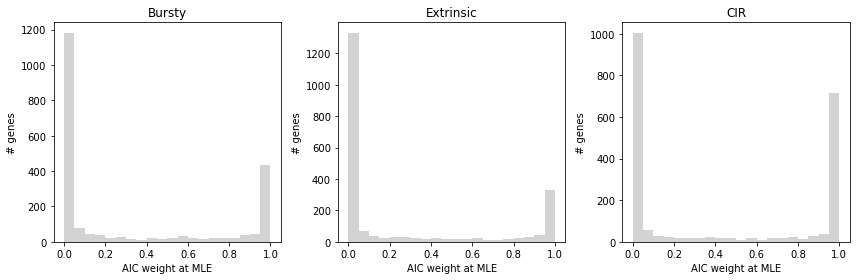

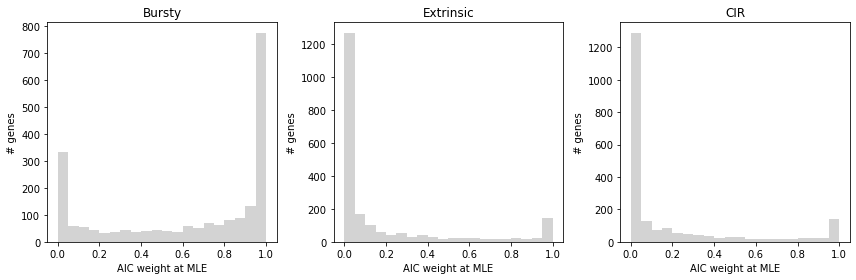

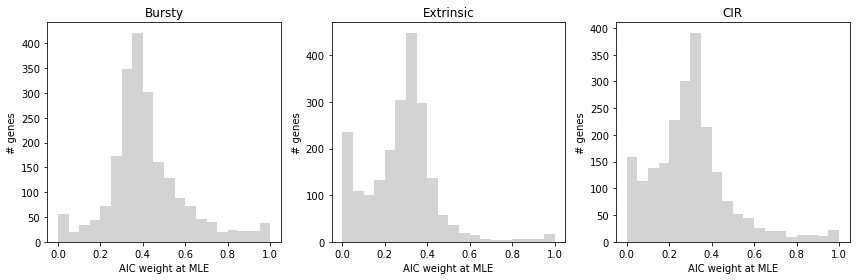

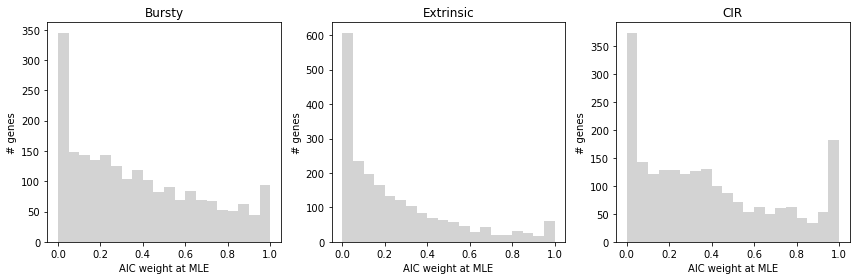

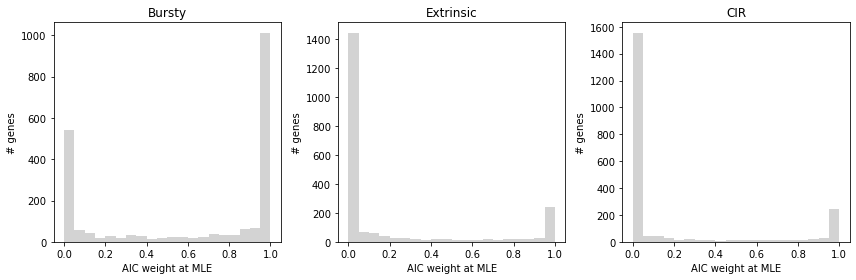

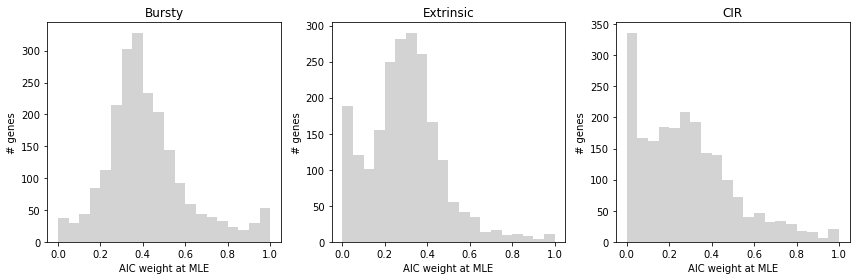

In [19]:
w = []

for j in range(n_datasets):
#     rs = result_strings[j]
    
#     sd = load_search_data(sd_strings[j])
    
#     sr_arr = []
#     for k in range(n_models):
#         sr = load_search_results(rs[k])
#         sr.find_sampling_optimum()
#         sr_arr.append(sr)
    
#     if j<len(dn1):
#         make_batch_analysis_dir(sr_arr,dir_string1)
#     else:
#         make_batch_analysis_dir(sr_arr,dir_string2)

    w_ = plot_AIC_weights(sr_arr[j],sd_arr[j],models,meta=dataset_names[j],savefig=True)
    w.append(w_)

We find that the constitutive model is essentially never selected as the optimal one; biological overdispersion is clearly mandatory to describe scRNA-seq joint distributions. However, surprisingly, we find quite a bit of variation in *which* overdispersed model is optimal.

In [20]:
w = np.asarray(w)

In [22]:
w.shape

(7, 3, 2130)

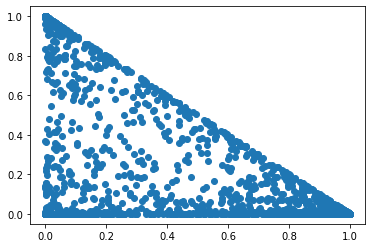

In [24]:
plt.scatter(w[0,0],w[0,2])

In [33]:
!pip install plotly

In [66]:
!pip install python-ternary

In [81]:
import importlib
importlib.reload(plotly)

<module 'plotly' from '/home/ggorin/miniconda3/lib/python3.9/site-packages/plotly/__init__.py'>

In [82]:
import plotly
import plotly.express as px
import pandas as pd

In [83]:
import ternary


In [84]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
n_cells = n_cells/n_cells.sum()
w_mean = (w*n_cells[:,None,None]).sum(0)

In [85]:
w_mean.shape

(3, 2130)

In [86]:
df = pd.DataFrame(data={models[k]:w_mean[k] for k in range(len(models))} )

In [87]:
df

,Bursty,Extrinsic,CIR
0,0.939079,0.013615,0.047305
1,0.765029,0.103356,0.131615
2,0.559727,0.009291,0.430982
3,0.201107,0.794175,0.004718
4,0.459532,0.057437,0.483031
...,...,...,...
2125,0.007646,0.627067,0.365287
2126,0.039728,0.955695,0.004577
2127,0.091669,0.014163,0.894169
2128,0.586675,0.013617,0.399708


In [88]:
models

('Bursty', 'Extrinsic', 'CIR')

In [89]:
fig = px.scatter_ternary(df,a=models[0],b=models[1],c=models[2])
fig.show()

In [92]:
import plotly.graph_objs as go
import numpy as np
from scipy.interpolate import griddata


In [93]:
A = np.array([0, .3 ,.25, .34 ,0, .4 ,.65, 0.05,  0,  1, .47, .2, .7])  #pos 10 1, 0, 0
B = np.array([1, .1, .45, .56, 0, .5, .3,  0.75, .85, 0,  .33, .3, .13])
C = np.array([0, .6 ,.3,  .1,  1, .1, .05,  .2,  .15, 0,  .2,  .5, .17])

z=np.array([1.27036107, 1.27893858, 0.52255697, 1.50035059, 0.84853798,
       1.27722501, 1.20920733, 0.88965008, 0.59293362, 0.9223051 ,
       1.57173859, 1.33606612, 1.08977333])
A+B+C


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [94]:
pl_ternary=dict(type='scatterternary',
                a=A,
                b=B, 
                c=C,
                mode='markers',
                marker=dict(size=10, color='red'))

layout=dict(width=500, height=400,
            ternary= {'sum':1,
                      'aaxis':{'title': 'a',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' },
                      'baxis':{'title': 'b',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' },
                      'caxis':{'title': 'c',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' }},
            showlegend= False,
            paper_bgcolor='#EBF0F8')

fw=go.FigureWidget(data=[pl_ternary], layout=layout)
fw #this plot is visible only when the notebook is run


FigureWidget({
    'data': [{'a': array([0.  , 0.3 , 0.25, 0.34, 0.  , 0.4 , 0.65, 0.05, 0.  , 1.  , 0.47, 0.2…

In [95]:
def tr_b2c2b():
    # returns the transformation matrix from barycentric to cartesian coordinates and conversely
    tri_verts = np.array([[0.5, np.sqrt(3)/2], [0, 0], [1, 0]])# reference triangle
    M = np.array([tri_verts[:,0], tri_verts[:, 1], np.ones(3)]) 
    return M, np.linalg.inv(M)   


In [96]:
def contour_trace(x, y, z, tooltip, 
                  colorscale='Viridis', reversescale=False,
                  linewidth=0.5, linecolor='rgb(150,150,150)'):
                  
    return  dict(type='contour',
                 x=x,
                 y=y,    
                 z=z,
                 text=tooltip,
                 hoverinfo='text',    
                 colorscale=colorscale,
                 reversescale=reversescale,
                 line=dict(width=linewidth, color=linecolor),
                 colorbar=dict(thickness=20, ticklen=4))


In [97]:
def barycentric_ticks(side):
    # side 0, 1 or  2; side j has 0 in the  j^th position of barycentric coords of tick origin
    # returns the list of tick origin barycentric coords
    p = 10
    if side == 0: #where a=0
        return np.array([(0, j/p, 1-j/p) for j in range(p-2, 0, -2)])
    elif side == 1: # b=0
        return np.array([(i/p, 0, 1-i/p)  for i in  range( 2, p, 2) ])
    elif side == 2: #c=0
        return np.array([(i/p, j/p, 0)  for i in range(p-2, 0, -2) for j in range(p-i, -1, -1)  if i+j==p])
    else:
        raise ValueError('The side can be only 0, 1, 2')



def cart_coord_ticks(side, t=0.01):
    # side 0, 1 or 2
    # each tick segment is parameterized as (x(s), y(s)), s in [0, t]
    global  M, xt, yt, posx, posy
    # M is the transformation matrix from barycentric to cartesian coords
    # xt, yt are the lists of x, resp y-coords of tick segments
    # posx, posy are the lists of ticklabel positions for side 0, 1, 2 (concatenated)
    
    baryc = barycentric_ticks(side)
    xy1 = np.dot(M, baryc.T)
    xs, ys = xy1[:2] 
    
    if side == 0:
        for i in range(4):
            xt.extend([xs[i], xs[i]+t, None])
            yt.extend([ys[i], ys[i]-np.sqrt(3)*t, None])
        posx.extend([xs[i]+t for i in range(4)])
        posy.extend([ys[i]-np.sqrt(3)*t for i in range(4)])
        
    elif  side == 1:
        for i in range(4):
            xt.extend([xs[i], xs[i]+t, None])
            yt.extend([ys[i], ys[i]+np.sqrt(3)*t, None])
        posx.extend([xs[i]+t for i in range(4)]) 
        posy.extend([ys[i]+np.sqrt(3)*t for i in range(4)])
        
    elif side == 2:
        for i in range(4):
            xt.extend([xs[i], xs[i]-2*t, None])
            yt.extend([ys[i], ys[i], None])
        posx.extend([xs[i]-2*t for i in range(4)])
        posy.extend([ys[i] for i in range(4)]) 
    else:
        raise ValueError('side can be only 0,1,2')


In [98]:
def ternary_layout(title='Ternary contour plot', width=550, height=525, 
                   fontfamily= 'Balto, sans-serif' , lfontsize=14,
                   plot_bgcolor='rgb(240,240,240)',
                   vertex_text=['a', 'b', 'c'], v_fontsize=14):

     return dict(title=title,
                 font=dict(family=fontfamily, size=lfontsize),
                 width=width, height=height,
                 xaxis=dict(visible=False),
                 yaxis=dict(visible=False),
                 plot_bgcolor=plot_bgcolor,
                 showlegend=False,
                 #annotations for strings  placed at the triangle vertices
                 annotations=[dict(showarrow=False,
                                   text=vertex_text[0],
                                   x=0.5,
                                   y=np.sqrt(3)/2,
                                   align='center',
                                   xanchor='center',
                                   yanchor='bottom',
                                   font=dict(size=v_fontsize)),
                              dict(showarrow=False,
                                   text=vertex_text[1],
                                   x=0,
                                   y=0,
                                   align='left',
                                   xanchor='right',
                                   yanchor='top',
                                   font=dict(size=v_fontsize)),
                              dict(showarrow=False,
                                   text=vertex_text[2],
                                   x=1,
                                   y=0,
                                   align='right',
                                   xanchor='left',
                                   yanchor='top',
                                   font=dict(size=v_fontsize))
                              ])


In [99]:
def set_ticklabels(annotations, posx, posy, proportion=True):
    #annotations: list of annotations previously defined in layout definition as a dict,
    #     not as an instance of go.Layout
    #posx, posy:  lists containing ticklabel position coordinates
    #proportion - boolean; True when ticklabels are 0.2, 0.4, ... False when they are 20%, 40%...
    
    if not isinstance(annotations, list):
        raise ValueError('annotations should be a list')
        
    ticklabel = [0.8, 0.6, 0.4, 0.2] if proportion else ['80%', '60%', '40%', '20%'] 
    
    annotations.extend([dict(showarrow=False, # annotations for ticklabels on side 0
                             text=f'{ticklabel[j]}',
                             x=posx[j],
                             y=posy[j],
                             align='center',
                             xanchor='center', 
                             yanchor='top',
                             font=dict(size=12)) for j in range(4)])
    
    annotations.extend([dict(showarrow=False, # annotations for ticklabels on  side 1
                             text=f'{ticklabel[j]}',
                             x=posx[j+4],
                             y=posy[j+4],
                             align='center',
                             xanchor='left', 
                             yanchor='middle',
                             font=dict(size=12)) for j in range(4)])

    annotations.extend([dict(showarrow=False, # annotations for ticklabels on side 2
                             text=f'{ticklabel[j]}',
                             x=posx[j+8],
                             y=posy[j+8],
                             align='center',
                             xanchor='right', 
                             yanchor='middle',
                             font=dict(size=12)) for j in range(4)])
    return annotations


In [108]:
def styling_traces():
    global xt, yt
    side_trace = dict(type='scatter',
                      x=[0.5, 0, 1, 0.5],
                      y=[np.sqrt(3)/2, 0, 0, np.sqrt(3)/2],
                      mode='lines',
                      line=dict(width=2, color='#444444'),
                      hoverinfo='none')
    
    tick_trace = dict(type='scatter',
                      x=xt,
                      y=yt,
                      mode='lines',
                      line=dict(width=1, color='#444444'),
                      hoverinfo='none')
    
    return side_trace, tick_trace


In [109]:
M, invM =  tr_b2c2b()


In [110]:
cartes_coord_points = np.einsum('ik, kj -> ij', M, np.stack((A, B, C)))
xx, yy = cartes_coord_points[:2]


In [111]:
a, b = xx.min(), xx.max()
c, d = yy.min(), yy.max()


In [112]:
N=150
gr_x = np.linspace(a,b, N)
gr_y = np.linspace(c,d, N)
grid_x, grid_y = np.meshgrid(gr_x, gr_y)

#interpolate data (cartes_coords[:2].T; z)  and evaluate the  interpolatory function at the meshgrid points to get grid_z
grid_z = griddata(cartes_coord_points[:2].T, z, (grid_x, grid_y), method='cubic')


In [113]:
bar_coords = np.einsum('ik, kmn -> imn', invM, np.stack((grid_x, grid_y, np.ones(grid_x.shape))))
bar_coords[np.where(bar_coords<0)] = None # invalidate the points outside of the reference triangle
xy1 = np.einsum('ik, kmn -> imn', M, bar_coords) # recompute back the cartesian coordinates of bar_coords with invalid positions
                                               # and extract indices where x are nan

I = np.where(np.isnan(xy1[0]))
grid_z[I] = None


In [114]:
t_proportions = [[f'a: {round(bar_coords[0][i,j], 2)}<br>b: {round(bar_coords[1][i,j], 2)}'+\
                  f'<br>c: {round(1-round(bar_coords[0][i,j], 2)-round(bar_coords[1][i,j], 2), 2)}'+\
                  f'<br>z: {round(grid_z[i,j],2)}'  if ~np.isnan(xy1[0][i,j]) else '' for j in range(N)]
                                       for i in range(N)] 

# tooltips for  percents, i.e. a+b+c=100
t_percents=[[f'a: {int(100*bar_coords[0][i,j]+0.5)}<br>b: {int(100*bar_coords[1][i,j]+0.5)}'+\
             f'<br>c: {100-int(100*bar_coords[0][i,j]+0.5)-int(100*bar_coords[1][i,j]+0.5)}'+\
             f'<br>z: {round(grid_z[i,j],2)}'  if ~np.isnan(xy1[0][i,j]) else '' for j in range(N)] 
                                         for i in range(N)] 


In [115]:
pl_deep = [[0.0, 'rgb(253, 253, 204)'],
           [0.1, 'rgb(201, 235, 177)'],
           [0.2, 'rgb(145, 216, 163)'],
           [0.3, 'rgb(102, 194, 163)'],
           [0.4, 'rgb(81, 168, 162)'],
           [0.5, 'rgb(72, 141, 157)'],
           [0.6, 'rgb(64, 117, 152)'],
           [0.7, 'rgb(61, 90, 146)'],
           [0.8, 'rgb(65, 64, 123)'],
           [0.9, 'rgb(55, 44, 80)'],
           [1.0, 'rgb(39, 26, 44)']]


In [116]:
xt = []
yt = []
posx = []
posy = []
for side in [0, 1, 2]:
    cart_coord_ticks(side, t=0.01)


tooltip = t_proportions
layout = ternary_layout()
annotations = set_ticklabels(layout['annotations'], posx, posy, proportion=True)

c_trace = contour_trace(gr_x, gr_y, grid_z, tooltip, colorscale=pl_deep, reversescale=True)
side_trace, tick_trace =styling_traces()
fw1 = go.FigureWidget(data=[c_trace,  tick_trace, side_trace], layout=layout)
fw1.layout.annotations=annotations
    
#fw1


In [122]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.6 MB/s  eta 0:00:01


In [125]:
import chart_studio.plotly as py

In [128]:
py.sign_in('ggorin', 'luhWOQy0nktF7R3cHmT1')

In [130]:
fw1

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'ticklen': 4},
              'colorscale': [[0.0, '…

In [129]:
py.iplot(fw1)

PlotlyRequestError: This file is too big! Your current subscription is limited to 524.288 KB uploads. For more information, please visit: https://plotly.com/get-pricing/.

In [27]:
subcluster_names

['l23it', 'l5it', 'l6it', 'l5et', 'l56np', 'l6ct', 'l6b']

In [31]:
sr_arr[0][0].batch_analysis_string

'./fits/gg_220602_022_allen_celltypes_1/analysis_figures'

In [10]:
w2 = w[len(dn1):]

In [11]:
dn1_ = [dn1[k] for k in (0,2,4,6,1,3,5,7)]

In [12]:
w1_ = np.asarray([w1[k] for k in (0,2,4,6,1,3,5,7)])

## Inter-dataset comparisons

Nevertheless, despite this instability, we do find certain broadly consistent trends. Technical replicates B08/A08 and B01/C01, when filtered for a particular cell type, tend to give similar weights to the bursty model (KDE has a significant peak at 0 and tends not to have it at 1). GABAergic cells are consistent between biological replicates, but glutamatergic are not, which is somewhat surprising since there are far more glutamatergic cells in the raw datasets.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_grid.png.


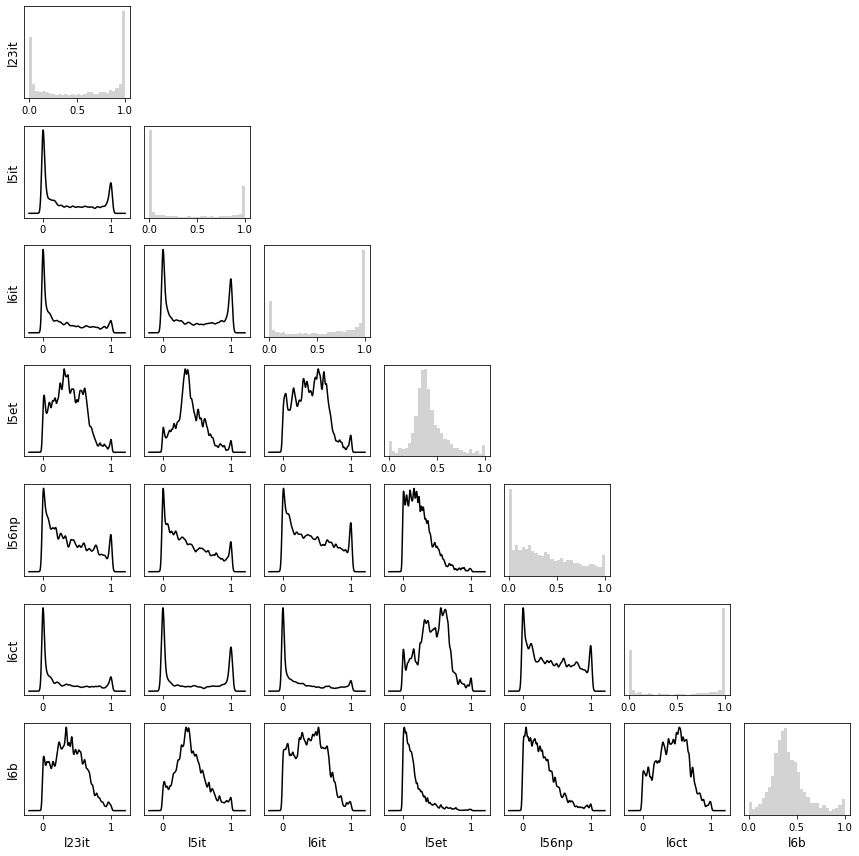

In [32]:
compare_AIC_weights(w,subcluster_names,sr_arr[0][0].batch_analysis_string)

In [15]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 291 seconds.
